## Le Recuit Simulé (Simulated Annealing)

Le **recuit simulé** est une **méthode d'optimisation stochastique** inspirée du processus physique de **recuit métallurgique**, où un métal est chauffé puis refroidi lentement pour atteindre une configuration minimale d'énergie.

### Principe
L'idée est d'explorer l'espace des solutions en acceptant non seulement les améliorations, mais aussi **certaines détériorations temporaires** de la solution. Cela permet d'**éviter les minima locaux**.

### Fonctionnement
1. **Initialisation** : On part d'une solution initiale et d'une température initiale élevée.
2. **Génération de voisin** : À chaque itération, une nouvelle solution voisine est générée.
3. **Évaluation** : Si elle est meilleure, on l'accepte. Si elle est pire, on l'accepte avec une probabilité qui diminue avec la température :
   \[
   P = e^{-\frac{\Delta E}{T}}
   \]
   où :
   - \( \Delta E \) est la variation de coût,
   - \( T \) est la température actuelle.
4. **Refroidissement** : La température est diminuée progressivement selon un **planning de refroidissement** (par exemple, \( T \leftarrow \alpha \cdot T \), avec \( 0 < \alpha < 1 \)).

### Avantages
- Évite les pièges des minima locaux.
- Facile à implémenter.
- Peu de paramètres à ajuster.

### Inconvénients
- Le choix du planning de refroidissement est crucial.
- Peut être lent à converger.

### Applications
- Problèmes combinatoires (comme le voyageur de commerce),
- Optimisation continue,
- Apprentissage automatique, etc.


In [1]:
# Cellule 1: Imports
import random
import numpy as np
from typing import List, Tuple, Set
import time
import matplotlib.pyplot as plt
import math

In [2]:
# Cellule 2: Fonction de chargement des données
def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        # Dernière ligne contient les points de collecte
        points_collecte = list(map(int, lines[-1].split(';')))
        
        # Matrice d'adjacence dans les autres lignes
        matrix = []
        for line in lines[:-1]:
            row = list(map(int, line.split(';')))
            matrix.append(row)
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

## Classe principale du Recuit Simulé

Cette classe implémente l'algorithme de recuit simulé pour résoudre le problème de tournée de véhicules.

Le recuit simulé est une méta-heuristique inspirée du processus physique de recuit en métallurgie. L'algorithme:
1. Part d'une solution initiale
2. Explore l'espace des solutions en acceptant parfois des solutions moins bonnes (pour éviter les minima locaux)
3. Réduit progressivement la "température" pour converger vers une solution optimale

In [3]:
class SimulatedAnnealingTSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        
        # Pré-calcul des villes accessibles depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }
        
        # Validation des entrées
        self._validate_inputs()
    
    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        # Vérification basique
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        # Points de collecte
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        # Toutes villes visitées exactement une fois (sauf départ/arrivée)
        if len(set(path)) != self.num_cities:
            return False
            
        # Chemins valides
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
                
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        """Construit une solution initiale avec une approche gloutonne en respectant les contraintes."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        # Premier mouvement vers le point de collecte le plus proche
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        nearest_collect = min(collect_candidates, 
                            key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        
        # Construction gloutonne du chemin
        while unvisited:
            last = path[-1]
            
            # Filtrer les villes accessibles non visitées
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            
            if not candidates:
                # Si aucun candidat valide, essayer de trouver un chemin valide
                candidates = list(unvisited)
                random.shuffle(candidates)
                
            # Sélectionner la ville la plus proche accessible
            next_city = None
            min_dist = float('inf')
            for c in candidates:
                if self.matrix[last-1][c-1] < min_dist and self.matrix[last-1][c-1] != -1:
                    min_dist = self.matrix[last-1][c-1]
                    next_city = c
            
            if next_city is None:
                return None
                
            path.append(next_city)
            unvisited.remove(next_city)
        
        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
            
        path.append(self.start_node)
        
        return path if self.is_valid_path(path) else None

    def generate_random_solution(self) -> List[int]:
        """Génère une solution aléatoire valide."""
        while True:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            # Ajout d'un point de collecte en deuxième position
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                continue
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            # Construction aléatoire mais valide du chemin
            while unvisited:
                last = path[-1]
                candidates = [c for c in self.accessible_from[last] if c in unvisited]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            # Retour au départ si possible
            if unvisited or self.matrix[path[-1]-1][self.start_node-1] == -1:
                continue
                
            path.append(self.start_node)
            
            if self.is_valid_path(path):
                return path

    def get_neighbor(self, path: List[int]) -> List[int]:
        """Génère un voisin valide de la solution actuelle."""
        while True:
            new_path = path.copy()
            
            # On ne modifie pas le départ, l'arrivée ou les points de collecte contraints
            mutable_positions = list(range(1, len(path)-1))
            if len(path) > 3:
                mutable_positions.remove(1)  # Ne pas muter le premier point de collecte
            if len(path) > 4:
                mutable_positions.remove(len(path)-2)  # Ne pas muter l'avant-dernier point
                
            if len(mutable_positions) < 2:
                return path
                
            # Choisir un type de mouvement aléatoire
            move_type = random.choice(['swap', 'inversion', 'insertion'])
            
            if move_type == 'swap':
                # Échange de deux villes
                i, j = random.sample(mutable_positions, 2)
                new_path[i], new_path[j] = new_path[j], new_path[i]
                
            elif move_type == 'inversion':
                # Inversion d'une sous-séquence
                start, end = sorted(random.sample(mutable_positions, 2))
                new_path[start:end+1] = new_path[start:end+1][::-1]
                
            elif move_type == 'insertion':
                # Déplacement d'une ville à une autre position
                i = random.choice(mutable_positions)
                city = new_path.pop(i)
                j = random.choice([p for p in mutable_positions if p != i])
                new_path.insert(j, city)
            
            # Vérifier si le nouveau chemin est valide
            if self.is_valid_path(new_path):
                return new_path

    def solve(self, initial_temp: float = 10000, cooling_rate: float = 0.99,
             min_temp: float = 0.1, max_iter: int = 10000):
        """Algorithme de recuit simulé."""
        start_time = time.time()
        
        # Génération de la solution initiale
        current_solution = self._greedy_construction() or self.generate_random_solution()
        current_cost = self.calculate_cost(current_solution)
        
        self.best_solution = current_solution.copy()
        self.best_cost = current_cost
        self.cost_history.append(current_cost)
        
        temp = initial_temp
        iteration = 0
        
        while temp > min_temp and iteration < max_iter:
            # Générer un voisin
            neighbor = self.get_neighbor(current_solution)
            neighbor_cost = self.calculate_cost(neighbor)
            
            # Calculer la différence de coût
            cost_diff = neighbor_cost - current_cost
            
            # Accepter ou rejeter le voisin
            if cost_diff < 0 or random.random() < math.exp(-cost_diff / temp):
                current_solution = neighbor
                current_cost = neighbor_cost
                
                # Mettre à jour la meilleure solution
                if current_cost < self.best_cost:
                    self.best_solution = current_solution.copy()
                    self.best_cost = current_cost
            
            # Enregistrer le meilleur coût à chaque itération
            self.cost_history.append(self.best_cost)
            
            # Refroidissement
            temp *= cooling_rate
            iteration += 1
            
            # Affichage progression
            if iteration % 100 == 0:
                print(f"Iter {iteration}: Temp={temp:.2f} Best={self.best_cost} Current={current_cost}")
        
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        
        # Visualisation
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Itération")
        plt.ylabel("Coût")
        plt.show()
        
        return self.best_solution, self.best_cost

## Validation des solutions

Cette partie implémente les méthodes pour valider les solutions et calculer leur coût.

- `is_valid_path`: Vérifie si un chemin respecte toutes les contraintes
- `calculate_cost`: Calcule le coût total d'une solution (longueur du trajet)

## Génération de solutions initiales

Deux méthodes pour générer des solutions initiales:
1. `_greedy_construction`: Approche gloutonne qui construit la solution pas à pas en choisissant toujours le meilleur mouvement local
2. `generate_random_solution`: Génère une solution aléatoire mais valide

Une bonne solution initiale peut accélérer la convergence de l'algorithme.

## Génération de voisins

La méthode `get_neighbor` génère des solutions voisines en utilisant trois opérations:
1. `swap`: Échange deux villes dans le parcours
2. `inversion`: Inverse une sous-séquence du parcours
3. `insertion`: Déplace une ville à une autre position

Ces opérations permettent d'explorer l'espace des solutions tout en garantissant que les solutions générées restent valides.

## Algorithme de Recuit Simulé

C'est le cœur de l'implémentation. L'algorithme:
1. Part d'une solution initiale
2. À chaque itération:
   - Génère un voisin
   - Décide de l'accepter ou non (en fonction de la température et de l'amélioration)
   - Réduit la température selon un taux de refroidissement
3. Garde trace de la meilleure solution trouvée

Les paramètres clés sont:
- `initial_temp`: Température initiale
- `cooling_rate`: Taux de refroidissement
- `min_temp`: Température minimale avant arrêt
- `max_iter`: Nombre maximum d'itérations

## Choix des paramètres pour l'heuristique de Recuit Simulé (Simulated Annealing)

Afin d'optimiser la résolution du problème pour différentes tailles de villes, les paramètres suivants sont choisis :

| Taille (nombre de villes) | Température initiale (`T_init`) | Température finale (`T_min`) | Taux de refroidissement (`cooling_rate`) | Nombre d'itérations par température |
|:---|:---|:---|:---|:---|
| 10 | 1000 | 1 | 0.95 | 50 |
| 20 | 2000 | 1 | 0.95 | 100 |
| 30 | 3000 | 1 | 0.95 | 150 |
| 40 | 4000 | 1 | 0.95 | 200 |
| 50 | 5000 | 1 | 0.95 | 250 |
| 75 | 7500 | 1 | 0.95 | 400 |
| 100 | 10000 | 1 | 0.95 | 500 |

### Explication des choix

- **Température initiale (`T_init`)** : proportionnelle au nombre de villes pour permettre une bonne exploration initiale.
- **Température minimale (`T_min`)** : fixée à 1 pour arrêter l'algorithme lorsque les mouvements deviennent insignifiants.
- **Taux de refroidissement (`cooling_rate`)** : fixé à 0.95 pour un refroidissement progressif, équilibrant exploration et exploitation.
- **Nombre d'itérations par température** : croît avec la taille pour mieux exploiter chaque palier de température.


## Exemple d'utilisation

Cette dernière partie montre comment utiliser la classe pour résoudre un problème concret.

## Paramètres :
- initial_temp : Plus elle est élevée, plus l'algo est exploratoire. Il accepte plus facilement des solutions moins bonnes au début
- cooling_rate : Facteur de réduction de la température à chaque itération. Plus il est proche de 1, plus le refroidissement est lent, donc plus de temps pour explorer
- min_temp : Température minimale atteinte avant d'arrêter l'algo. Marque la fin de l'exploration
- max_iter : Nombre max d'itérations autorisées. S'arrête même si la température minimale n'est pas atteinte.

Chargement du fichier ../data/matrice_routes_ordre_10.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [3, 7]
- Taille de la matrice: (10, 10)
Iter 100: Temp=6057.70 Best=761 Current=1095
Iter 200: Temp=3669.58 Best=761 Current=1016
Iter 300: Temp=2222.92 Best=761 Current=1110
Iter 400: Temp=1346.58 Best=713 Current=713
Iter 500: Temp=815.72 Best=713 Current=1194
Iter 600: Temp=494.14 Best=699 Current=825
Iter 700: Temp=299.33 Best=699 Current=998
Iter 800: Temp=181.33 Best=678 Current=853
Iter 900: Temp=109.84 Best=678 Current=925
Iter 1000: Temp=66.54 Best=678 Current=867
Iter 1100: Temp=40.31 Best=678 Current=766
Iter 1200: Temp=24.42 Best=668 Current=712
Iter 1300: Temp=14.79 Best=668 Current=668
Iter 1400: Temp=8.96 Best=668 Current=668
Iter 1500: Temp=5.43 Best=668 Current=668
Iter 1600: Temp=3.29 Best=668 Current=668
Iter 1700: Temp=1.99 Best=668 Current=668
Iter 1800: Temp=1.21 Best=668 Current=668
Iter 1900: Temp=0.73 Best=668 Current=668
Iter 2000:

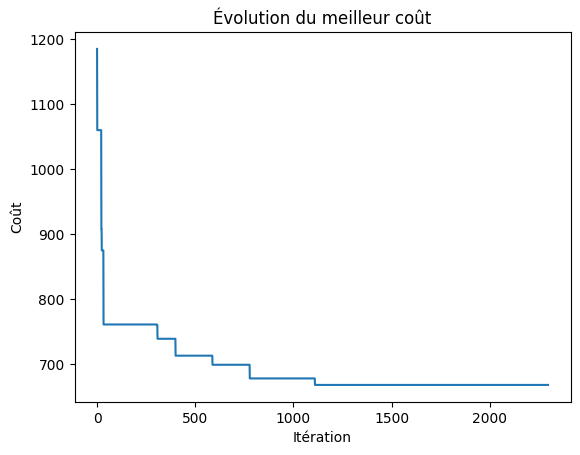


Meilleur chemin trouvé (extrait):
Départ: [1, 7, 10]...[6, 9, 1]
Longueur: 11 villes
Coût total: 668
Chargement du fichier ../data/matrice_routes_ordre_20.csv...

Paramètres du problème:
- Nombre de villes: 20
- Points de collecte: [5, 13]
- Taille de la matrice: (20, 20)
Iter 100: Temp=6057.70 Best=1025 Current=2476
Iter 200: Temp=3669.58 Best=1025 Current=1847
Iter 300: Temp=2222.92 Best=1025 Current=2210
Iter 400: Temp=1346.58 Best=1025 Current=2582
Iter 500: Temp=815.72 Best=1025 Current=2195
Iter 600: Temp=494.14 Best=1025 Current=2123
Iter 700: Temp=299.33 Best=1025 Current=2208
Iter 800: Temp=181.33 Best=1025 Current=1996
Iter 900: Temp=109.84 Best=1025 Current=2008
Iter 1000: Temp=66.54 Best=1025 Current=1705
Iter 1100: Temp=40.31 Best=1025 Current=1122
Iter 1200: Temp=24.42 Best=1025 Current=1103
Iter 1300: Temp=14.79 Best=1025 Current=1033
Iter 1400: Temp=8.96 Best=1025 Current=1033
Iter 1500: Temp=5.43 Best=1025 Current=1033
Iter 1600: Temp=3.29 Best=1025 Current=1033
Iter 

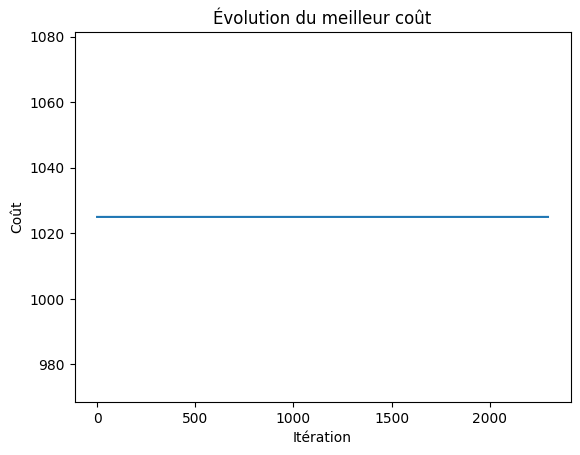


Meilleur chemin trouvé (extrait):
Départ: [1, 13, 5]...[10, 7, 1]
Longueur: 21 villes
Coût total: 1025
Chargement du fichier ../data/matrice_routes_ordre_30.csv...

Paramètres du problème:
- Nombre de villes: 30
- Points de collecte: [5, 14]
- Taille de la matrice: (30, 30)
Iter 100: Temp=6057.70 Best=1056 Current=2847
Iter 200: Temp=3669.58 Best=1056 Current=2828
Iter 300: Temp=2222.92 Best=1056 Current=3432
Iter 400: Temp=1346.58 Best=1056 Current=3020
Iter 500: Temp=815.72 Best=1056 Current=2918
Iter 600: Temp=494.14 Best=1056 Current=2969
Iter 700: Temp=299.33 Best=1056 Current=2954
Iter 800: Temp=181.33 Best=1056 Current=2010
Iter 900: Temp=109.84 Best=1056 Current=2541
Iter 1000: Temp=66.54 Best=1056 Current=1562
Iter 1100: Temp=40.31 Best=1056 Current=1873
Iter 1200: Temp=24.42 Best=1056 Current=1340
Iter 1300: Temp=14.79 Best=1055 Current=1055
Iter 1400: Temp=8.96 Best=1043 Current=1043
Iter 1500: Temp=5.43 Best=971 Current=971
Iter 1600: Temp=3.29 Best=914 Current=914
Iter 17

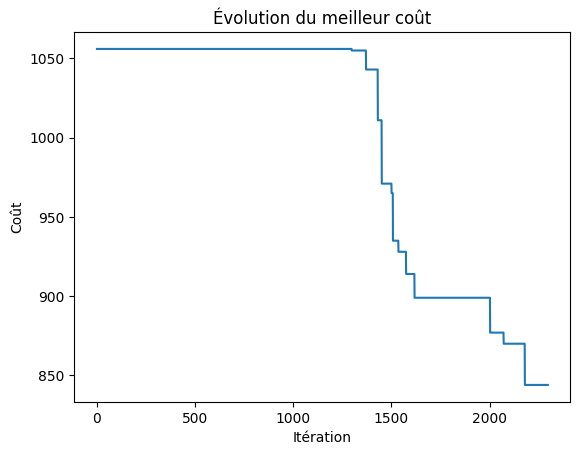


Meilleur chemin trouvé (extrait):
Départ: [1, 5, 11]...[25, 12, 1]
Longueur: 31 villes
Coût total: 844
Chargement du fichier ../data/matrice_routes_ordre_40_Difficile.csv...

Paramètres du problème:
- Nombre de villes: 40
- Points de collecte: [37, 19]
- Taille de la matrice: (40, 40)
Iter 100: Temp=6057.70 Best=782 Current=4670
Iter 200: Temp=3669.58 Best=782 Current=4835
Iter 300: Temp=2222.92 Best=782 Current=3870
Iter 400: Temp=1346.58 Best=782 Current=3358
Iter 500: Temp=815.72 Best=782 Current=3456
Iter 600: Temp=494.14 Best=782 Current=4158
Iter 700: Temp=299.33 Best=782 Current=4363
Iter 800: Temp=181.33 Best=782 Current=2978
Iter 900: Temp=109.84 Best=782 Current=2938
Iter 1000: Temp=66.54 Best=782 Current=2305
Iter 1100: Temp=40.31 Best=782 Current=2034
Iter 1200: Temp=24.42 Best=782 Current=1608
Iter 1300: Temp=14.79 Best=782 Current=1458
Iter 1400: Temp=8.96 Best=782 Current=1304
Iter 1500: Temp=5.43 Best=782 Current=1212
Iter 1600: Temp=3.29 Best=782 Current=1212
Iter 170

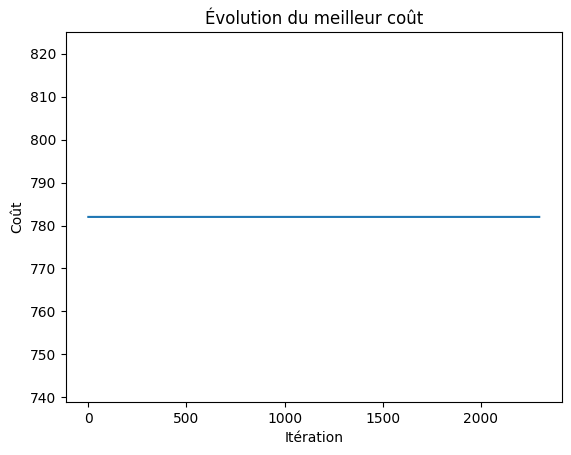


Meilleur chemin trouvé (extrait):
Départ: [1, 37, 40]...[30, 6, 1]
Longueur: 41 villes
Coût total: 782
Chargement du fichier ../data/matrice_routes_ordre_50.csv...

Paramètres du problème:
- Nombre de villes: 50
- Points de collecte: [34, 9]
- Taille de la matrice: (50, 50)
Iter 100: Temp=6057.70 Best=3759 Current=4787
Iter 200: Temp=3669.58 Best=3759 Current=5426
Iter 300: Temp=2222.92 Best=3759 Current=5125
Iter 400: Temp=1346.58 Best=3759 Current=5461
Iter 500: Temp=815.72 Best=3759 Current=4328
Iter 600: Temp=494.14 Best=3759 Current=4321
Iter 700: Temp=299.33 Best=3535 Current=4459
Iter 800: Temp=181.33 Best=3535 Current=4053
Iter 900: Temp=109.84 Best=3401 Current=3667
Iter 1000: Temp=66.54 Best=3355 Current=3673
Iter 1100: Temp=40.31 Best=2403 Current=2403
Iter 1200: Temp=24.42 Best=2059 Current=2059
Iter 1300: Temp=14.79 Best=1997 Current=1997
Iter 1400: Temp=8.96 Best=1671 Current=1671
Iter 1500: Temp=5.43 Best=1556 Current=1556
Iter 1600: Temp=3.29 Best=1235 Current=1235
Ite

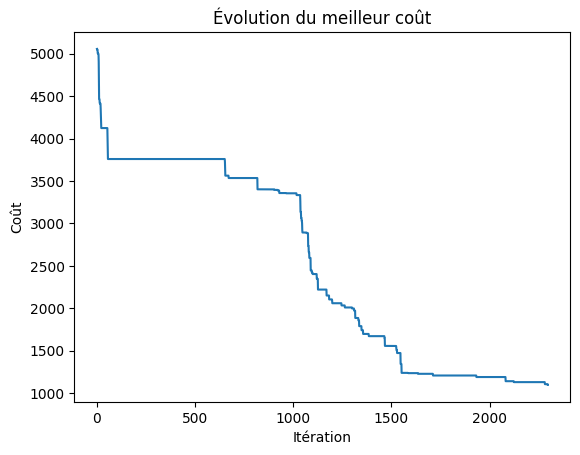


Meilleur chemin trouvé (extrait):
Départ: [1, 34, 49]...[39, 35, 1]
Longueur: 51 villes
Coût total: 1096
Chargement du fichier ../data/matrice_routes_ordre_75.csv...

Paramètres du problème:
- Nombre de villes: 75
- Points de collecte: [25, 37]
- Taille de la matrice: (75, 75)
Iter 100: Temp=6057.70 Best=6750 Current=6900
Iter 200: Temp=3669.58 Best=6455 Current=6944
Iter 300: Temp=2222.92 Best=6455 Current=7730
Iter 400: Temp=1346.58 Best=6455 Current=7082
Iter 500: Temp=815.72 Best=6455 Current=7029
Iter 600: Temp=494.14 Best=6455 Current=8170
Iter 700: Temp=299.33 Best=6455 Current=7501
Iter 800: Temp=181.33 Best=5989 Current=6242
Iter 900: Temp=109.84 Best=5688 Current=5749
Iter 1000: Temp=66.54 Best=5240 Current=5266
Iter 1100: Temp=40.31 Best=4678 Current=4741
Iter 1200: Temp=24.42 Best=4247 Current=4382
Iter 1300: Temp=14.79 Best=3838 Current=3880
Iter 1400: Temp=8.96 Best=3732 Current=3732
Iter 1500: Temp=5.43 Best=3212 Current=3212
Iter 1600: Temp=3.29 Best=2999 Current=2999


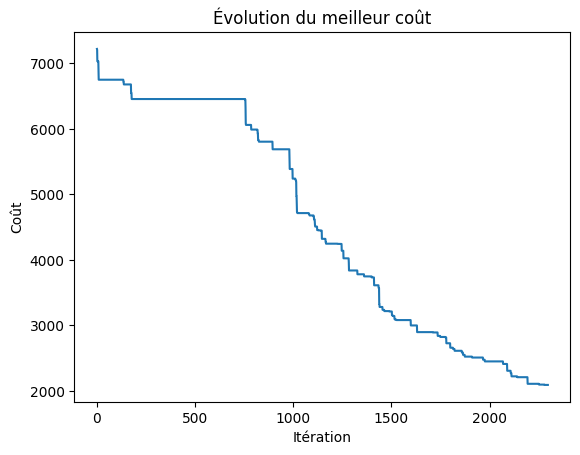


Meilleur chemin trouvé (extrait):
Départ: [1, 25, 28]...[27, 19, 1]
Longueur: 76 villes
Coût total: 2091
Chargement du fichier ../data/matrice_routes_ordre_100.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [46, 13]
- Taille de la matrice: (100, 100)
Iter 100: Temp=6057.70 Best=9238 Current=9991
Iter 200: Temp=3669.58 Best=9238 Current=10213
Iter 300: Temp=2222.92 Best=8664 Current=9089
Iter 400: Temp=1346.58 Best=8664 Current=9335
Iter 500: Temp=815.72 Best=8664 Current=8997
Iter 600: Temp=494.14 Best=8664 Current=9585
Iter 700: Temp=299.33 Best=8664 Current=9245
Iter 800: Temp=181.33 Best=8472 Current=8917
Iter 900: Temp=109.84 Best=7757 Current=7774
Iter 1000: Temp=66.54 Best=7450 Current=7694
Iter 1100: Temp=40.31 Best=6500 Current=6504
Iter 1200: Temp=24.42 Best=5838 Current=5838
Iter 1300: Temp=14.79 Best=5037 Current=5063
Iter 1400: Temp=8.96 Best=4302 Current=4302
Iter 1500: Temp=5.43 Best=3923 Current=3923
Iter 1600: Temp=3.29 Best=3795 Current=

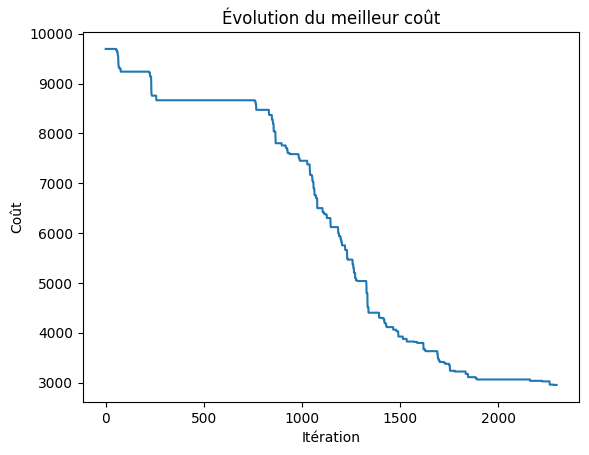


Meilleur chemin trouvé (extrait):
Départ: [1, 13, 24]...[11, 10, 1]
Longueur: 101 villes
Coût total: 2953
Chargement du fichier ../data/matrice_routes_ordre_generation_aleatoire.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [96, 56]
- Taille de la matrice: (100, 100)
Iter 100: Temp=6057.70 Best=8697 Current=9297
Iter 200: Temp=3669.58 Best=8697 Current=10483
Iter 300: Temp=2222.92 Best=8697 Current=9551
Iter 400: Temp=1346.58 Best=8697 Current=10259
Iter 500: Temp=815.72 Best=8697 Current=9562
Iter 600: Temp=494.14 Best=8697 Current=9626
Iter 700: Temp=299.33 Best=8008 Current=8747
Iter 800: Temp=181.33 Best=7222 Current=7386
Iter 900: Temp=109.84 Best=7148 Current=7602
Iter 1000: Temp=66.54 Best=6742 Current=6917
Iter 1100: Temp=40.31 Best=6332 Current=6389
Iter 1200: Temp=24.42 Best=5541 Current=5541
Iter 1300: Temp=14.79 Best=5353 Current=5353
Iter 1400: Temp=8.96 Best=4739 Current=4739
Iter 1500: Temp=5.43 Best=4421 Current=4421
Iter 1600: Temp=3.29

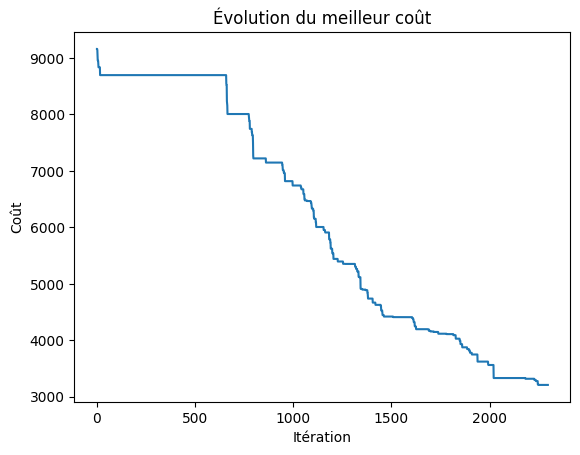


Meilleur chemin trouvé (extrait):
Départ: [1, 96, 24]...[2, 9, 1]
Longueur: 101 villes
Coût total: 3210


In [5]:
# Cellule 8: Exemple d'utilisation
if __name__ == "__main__":
    try:
        liste = ["../data/matrice_routes_ordre_10.csv",
                 "../data/matrice_routes_ordre_20.csv",
                 "../data/matrice_routes_ordre_30.csv",
                 "../data/matrice_routes_ordre_40_Difficile.csv",
                 "../data/matrice_routes_ordre_50.csv",
                 "../data/matrice_routes_ordre_75.csv",
                 "../data/matrice_routes_ordre_100.csv",
                 "../data/matrice_routes_ordre_generation_aleatoire.csv"
                 ]
        for i in range(len(liste)):
            file_path = liste[i]  # Remplacez par votre chemin
            print(f"Chargement du fichier {file_path}...")
            matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
            
            print("\nParamètres du problème:")
            print(f"- Nombre de villes: {len(matrix)}")
            print(f"- Points de collecte: {collecte}")
            print(f"- Taille de la matrice: {matrix.shape}")
            
            # Résolution
            solver = SimulatedAnnealingTSP(matrix, collecte)
            solution, cost = solver.solve(
                initial_temp=10000,
                cooling_rate=0.995,
                min_temp=0.1,
                max_iter=5000
            )
            
            print("\nMeilleur chemin trouvé (extrait):")
            print(f"Départ: {solution[:3]}...{solution[-3:]}")
            print(f"Longueur: {len(solution)} villes")
            print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"Erreur: {str(e)}")

## Sources :

- https://www.i2m.univ-amu.fr/perso/jean-philippe.preaux/PDF/pdf_proteges/OptimisationCombinatoire/Metaheuristiques2.pdf
- http://www.lps.ens.fr/~weisbuch/livre/b9.html